In [21]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# torch.set_num_threads(1)

### 1 Learning to predict the Lorenz system using RNNs

In [22]:
class CustomDataset(Dataset):
    """Sample random subsequences of length T_seq from the provided dataset.
    The dataset is a torch tensor of shape (T, N)."""

    def __init__(self, data, T_seq):
        # T x N
        self.data = data
        self.T_seq = T_seq

    def __getitem__(self, t):
        # t is the index of the first time step
        # return a sequence of length T_seq
        # and the sequence shifted by one time step
        return (
            self.data[t : t + self.T_seq, :],
            self.data[t + 1 : t + self.T_seq + 1, :],
        )

    def __len__(self):
        # sets the allowed range of t
        return len(self.data) - self.T_seq - 1


class BatchSampler:
    """Samples sequences from the dataset and stacks them into batches."""

    def __init__(self, dataset, batch_size):
        self.B = batch_size
        self.dataset = dataset

    def __call__(self):
        # get indices
        batch = [self.dataset[i] for i in self.get_random_inital_conditions()]

        # stack the sequences into separate batches
        xs = torch.stack([x for x, _ in batch])
        ys = torch.stack([y for _, y in batch])

        # reshape to (T, B, N)
        return xs.permute(1, 0, 2), ys.permute(1, 0, 2)

    def get_random_inital_conditions(self):
        # return a list of initial conditions of size self.B
        return torch.randperm(len(self.dataset))[: self.B]

In [23]:
def train_RNN(rnn, output_layer, dataloader, n_epochs, print_every, lr=5e-4):
    # gather parameters
    rnn_params = list(rnn.parameters())
    output_layer_params = list(output_layer.parameters())

    # the optimizer performing stochastic gradient descent
    optimizer = torch.optim.Adam(rnn_params + output_layer_params, lr=lr)

    # the loss function
    criterion = nn.MSELoss()

    losses = []
    for epoch in range(n_epochs + 1):
        # get the data
        xs, ys = dataloader()

        # zero the gradients
        optimizer.zero_grad()

        # forward pass of the entire batch
        # implicitly initializes the hidden state
        # to zero!
        out, h = rnn(xs)
        y_pred = output_layer(out)

        # compute the loss
        loss = criterion(y_pred, ys)

        # backward pass, computes gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # store the loss
        losses.append(loss.item())

        # print the loss
        if epoch % print_every == 0:
            print("Epoch: {}, Loss: {:.5f}".format(epoch, loss.item()))

    return losses

In [24]:
# set the parameters
T_seq = 200  # seq length
B = 32  # batchsize
learning_rate = 5e-4  # you can play around with this setting

# load the data
X = torch.load("lorenz_data.pt")
print(X.size())

# initialize the dataset
dataset = CustomDataset(X, T_seq)

# initialize the dataloader
dataloader = BatchSampler(dataset, B)
xs, ys = dataloader()
print(xs.size(), ys.size())

torch.Size([100000, 3])
torch.Size([200, 32, 3]) torch.Size([200, 32, 3])


/tmp/ipykernel_948811/1190815756.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load("lorenz_data.pt")


In [25]:
def make_model(epochs: int, hidden_size: int):

    rnn = nn.RNN(
        input_size=3, hidden_size=hidden_size, num_layers=1, nonlinearity="relu"
    )
    output_layer = nn.Linear(hidden_size, 3)

    losses = train_RNN(
        rnn,
        output_layer,
        dataloader,
        n_epochs=epochs,
        print_every=int(epochs / 10),
        lr=learning_rate,
    )

    return rnn, losses


def make_losses(epochs: int, hidden_sizes: list[int]):
    losses = []
    for s in hidden_sizes:
        print("*** training for size=%d ***" % s)
        model, l = make_model(epochs, s)
        losses.append((l, s))
    return losses


def plot_losses(losses: list[tuple[list[float], int]]):
    fig = plt.figure()
    ax = fig.add_subplot()
    for l, s in losses:
        ax.plot(l, label="hidden size: %d" % s)
        ax.set_title("Losses")
        ax.set_yscale("log")
    fig.legend()
    fig.show()

In [26]:
losses = make_losses(2000, [3, 50, 150])

*** training for size=3 ***
Epoch: 0, Loss: 1.51397
Epoch: 200, Loss: 1.16024
Epoch: 400, Loss: 0.88297
Epoch: 600, Loss: 0.70099
Epoch: 800, Loss: 0.55336
Epoch: 1000, Loss: 0.40772
Epoch: 1200, Loss: 0.27276
Epoch: 1400, Loss: 0.26969
Epoch: 1600, Loss: 0.19452
Epoch: 1800, Loss: 0.18693
Epoch: 2000, Loss: 0.15483
*** training for size=50 ***
Epoch: 0, Loss: 1.08739
Epoch: 200, Loss: 0.01151
Epoch: 400, Loss: 0.00751
Epoch: 600, Loss: 0.00451
Epoch: 800, Loss: 0.00370
Epoch: 1000, Loss: 0.00267
Epoch: 1200, Loss: 0.00249
Epoch: 1400, Loss: 0.00285
Epoch: 1600, Loss: 0.00209
Epoch: 1800, Loss: 0.00187
Epoch: 2000, Loss: 0.00151
*** training for size=150 ***
Epoch: 0, Loss: 1.01981
Epoch: 200, Loss: 0.00811
Epoch: 400, Loss: 0.00246
Epoch: 600, Loss: 0.00149
Epoch: 800, Loss: 0.00096
Epoch: 1000, Loss: 0.00041
Epoch: 1200, Loss: 0.00027
Epoch: 1400, Loss: 0.00021
Epoch: 1600, Loss: 0.00019
Epoch: 1800, Loss: 0.00016
Epoch: 2000, Loss: 0.00012


/tmp/ipykernel_948811/1572029178.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


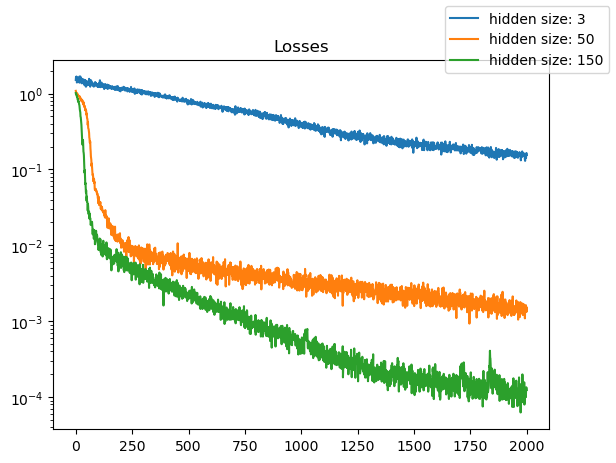

In [27]:
plot_losses(losses)